In [1]:
# Import Required Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Set style for plots
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# **Load and Explore the Dataset**

In [3]:
# Load the dataset
df = pd.read_csv('Imdb - data_imdb.csv')

# Check the first few rows
print(df.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [4]:
# Check dataset info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19780 entries, 0 to 19779
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     19780 non-null  object
 1   sentiment  19779 non-null  object
dtypes: object(2)
memory usage: 309.2+ KB
None


In [5]:
# Check class distribution
print(df['sentiment'].value_counts())

sentiment
negative    9993
positive    9786
Name: count, dtype: int64


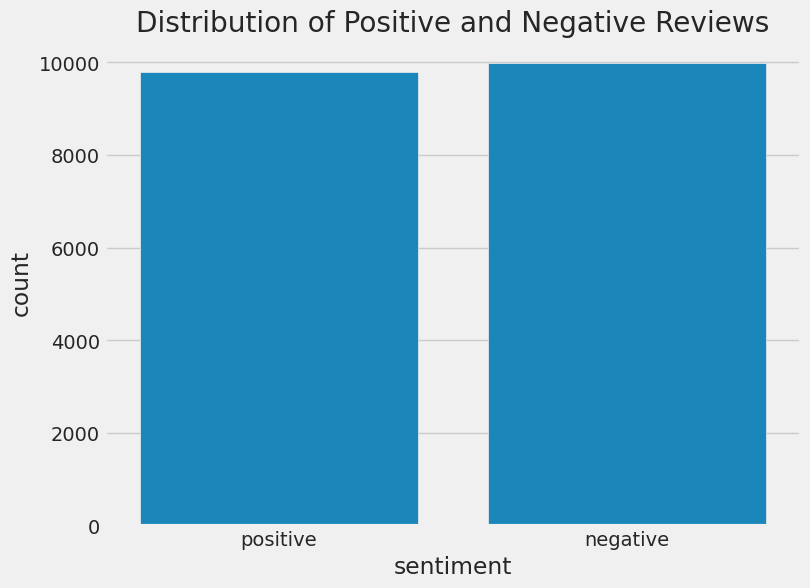

In [6]:
# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Positive and Negative Reviews')
plt.show()

# **Text Preprocessing**

In [7]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [8]:
def clean_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)

    # Tokenize text
    tokens = word_tokenize(text)

    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    # Join tokens back into string
    clean_text = ' '.join(tokens)

    return clean_text

In [10]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [11]:
# Apply cleaning to reviews
df['cleaned_review'] = df['review'].apply(clean_text)

In [12]:
# Add some text statistics
df['word_count'] = df['cleaned_review'].apply(lambda x: len(x.split()))
df['char_count'] = df['cleaned_review'].apply(len)
df['avg_word_length'] = df['cleaned_review'].apply(lambda x: np.mean([len(word) for word in x.split()]))

In [13]:
# Show cleaned data
print(df[['review', 'cleaned_review', 'word_count', 'char_count', 'avg_word_length']].head())

                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   
4  Petter Mattei's "Love in the Time of Money" is...   

                                      cleaned_review  word_count  char_count  \
0  one reviewer mentioned watching oz episode you...         170        1134   
1  wonderful little production br br filming tech...          90         658   
2  thought wonderful way spend time hot summer we...          87         582   
3  basically there family little boy jake think t...          70         459   
4  petter matteis love time money visually stunni...         130         864   

   avg_word_length  
0         5.676471  
1         6.322222  
2         5.701149  
3         5.571429  
4         5.653846  


# **Exploratory Data Analysis**

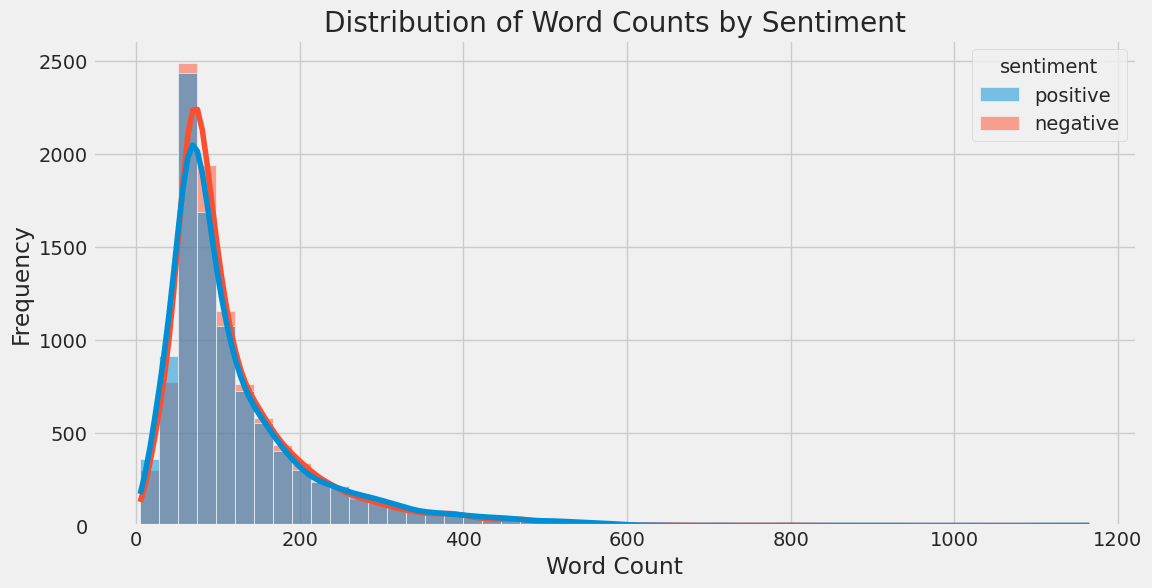

In [14]:
# Plot distribution of word counts
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='word_count', hue='sentiment', bins=50, kde=True)
plt.title('Distribution of Word Counts by Sentiment')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

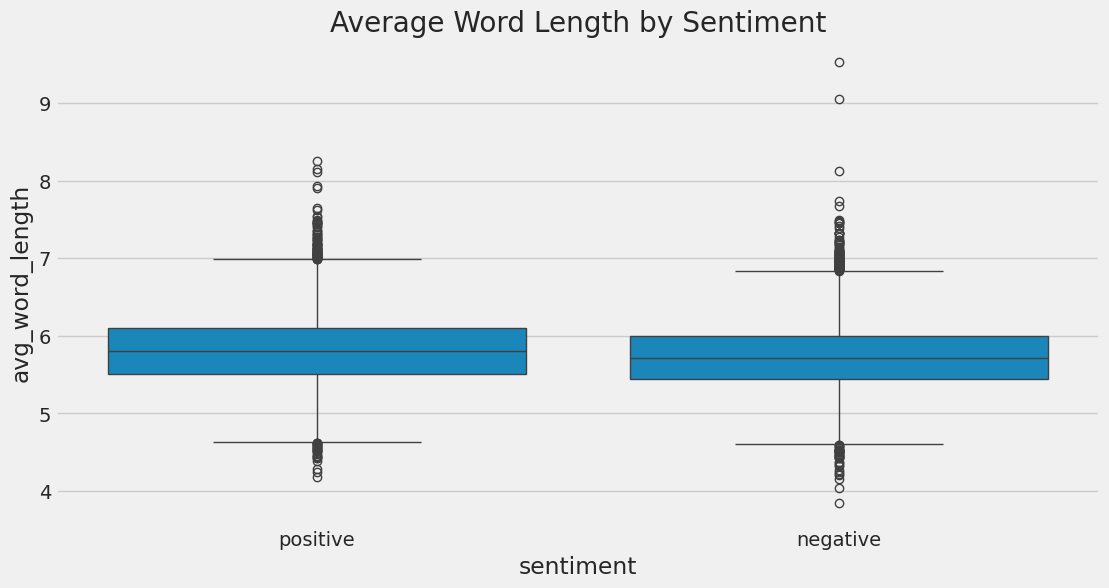

In [15]:
# Plot average word length
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='sentiment', y='avg_word_length')
plt.title('Average Word Length by Sentiment')
plt.show()

In [16]:
# Check most common words
from collections import Counter

def get_top_words(corpus, n=None):
    words = ' '.join(corpus).split()
    return Counter(words).most_common(n)

In [17]:
# Top words in positive reviews
pos_words = get_top_words(df[df['sentiment'] == 'positive']['cleaned_review'], 20)
print("Top words in positive reviews:", pos_words)

Top words in positive reviews: [('br', 22257), ('film', 18727), ('movie', 16961), ('one', 10729), ('like', 6910), ('time', 5910), ('good', 5685), ('story', 5338), ('character', 5294), ('great', 4958), ('see', 4914), ('well', 4442), ('get', 4316), ('make', 4230), ('also', 4160), ('really', 4152), ('would', 4117), ('scene', 3782), ('show', 3779), ('even', 3639)]


In [18]:
# Top words in negative reviews
neg_words = get_top_words(df[df['sentiment'] == 'negative']['cleaned_review'], 20)
print("Top words in negative reviews:", neg_words)

Top words in negative reviews: [('br', 23835), ('movie', 22390), ('film', 16607), ('one', 10355), ('like', 8925), ('even', 6093), ('good', 5767), ('bad', 5713), ('time', 5631), ('would', 5538), ('character', 5524), ('get', 5512), ('make', 5136), ('really', 4877), ('scene', 4459), ('see', 4427), ('story', 4299), ('dont', 4120), ('much', 3912), ('people', 3726)]


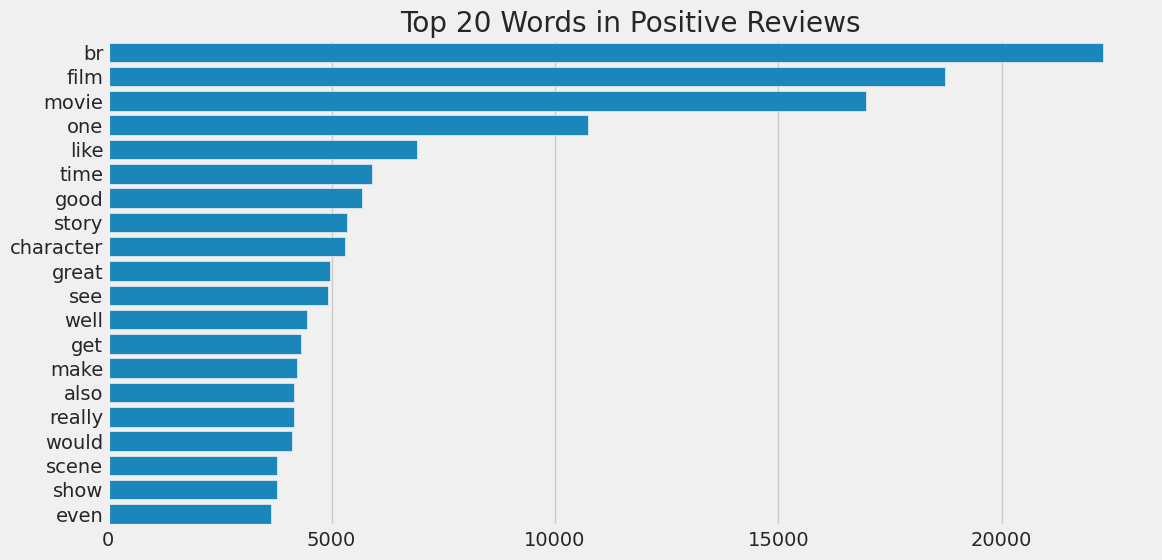

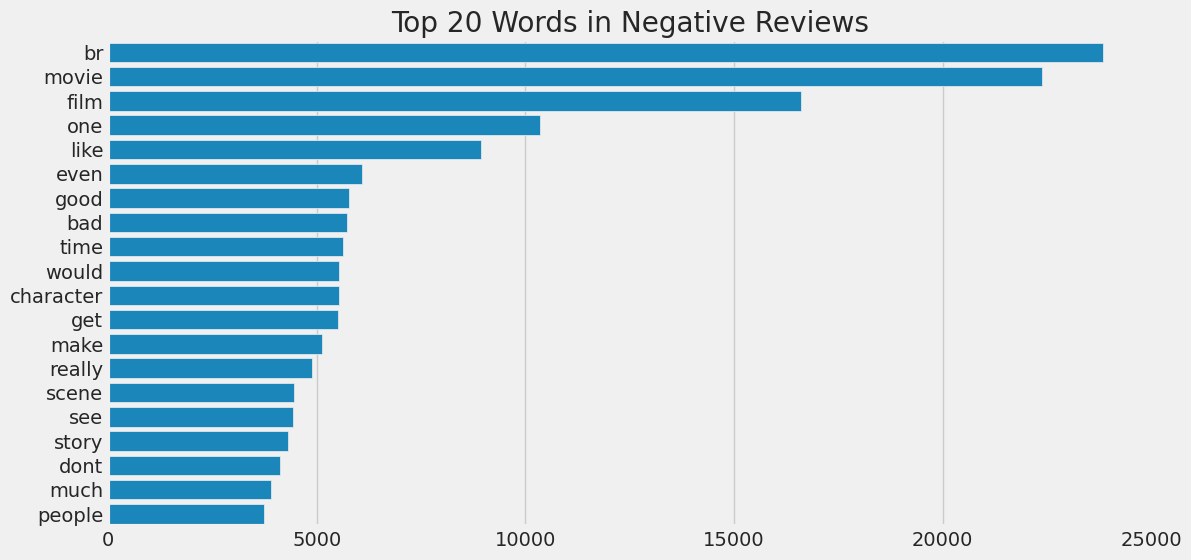

In [19]:
# Plot top words
def plot_top_words(word_list, title):
    words, counts = zip(*word_list)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(counts), y=list(words))
    plt.title(title)
    plt.show()

plot_top_words(pos_words, 'Top 20 Words in Positive Reviews')
plot_top_words(neg_words, 'Top 20 Words in Negative Reviews')

In [20]:
# Convert sentiment to numerical values (1 for positive, 0 for negative)
df['sentiment_num'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [21]:
# Split data into train and test sets
X = df['cleaned_review']
y = df['sentiment_num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

In [23]:
# Fit and transform train data
X_train_tfidf = tfidf.fit_transform(X_train)

In [24]:
# Transform test data
X_test_tfidf = tfidf.transform(X_test)

In [25]:
print(f"TF-IDF shape for training data: {X_train_tfidf.shape}")
print(f"TF-IDF shape for test data: {X_test_tfidf.shape}")

TF-IDF shape for training data: (15824, 10000)
TF-IDF shape for test data: (3956, 10000)


# **Model Building and Evaluation**

In [26]:
# Dictionary to store model performance
model_results = {}

def train_and_evaluate(model, model_name):
    # Train the model
    model.fit(X_train_tfidf, y_train)

    # Predict on test data
    y_pred = model.predict(X_test_tfidf)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['negative', 'positive'])
    cm = confusion_matrix(y_test, y_pred)

    # Store results
    model_results[model_name] = {
        'accuracy': accuracy,
        'report': report,
        'confusion_matrix': cm
    }

    # Print results
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)

    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['negative', 'positive'],
                yticklabels=['negative', 'positive'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [27]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Naive Bayes': MultinomialNB(),
    'Support Vector Machine': SVC(kernel='linear', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}


Logistic Regression Results:
Accuracy: 0.8880

Classification Report:
              precision    recall  f1-score   support

    negative       0.91      0.87      0.89      2049
    positive       0.87      0.91      0.89      1907

    accuracy                           0.89      3956
   macro avg       0.89      0.89      0.89      3956
weighted avg       0.89      0.89      0.89      3956



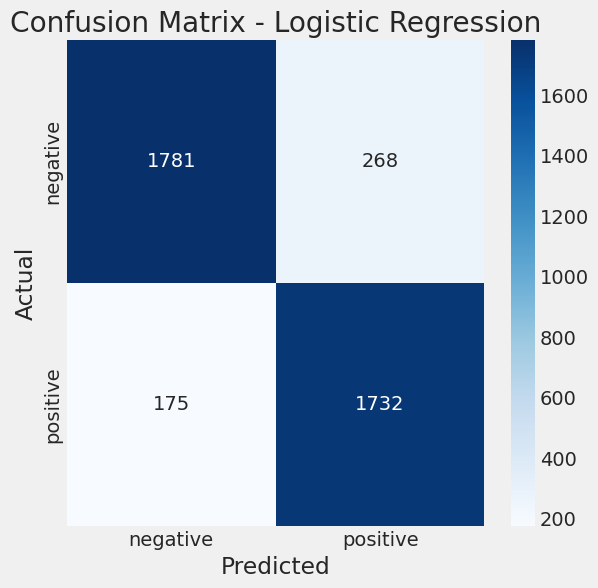


Naive Bayes Results:
Accuracy: 0.8658

Classification Report:
              precision    recall  f1-score   support

    negative       0.88      0.86      0.87      2049
    positive       0.85      0.87      0.86      1907

    accuracy                           0.87      3956
   macro avg       0.87      0.87      0.87      3956
weighted avg       0.87      0.87      0.87      3956



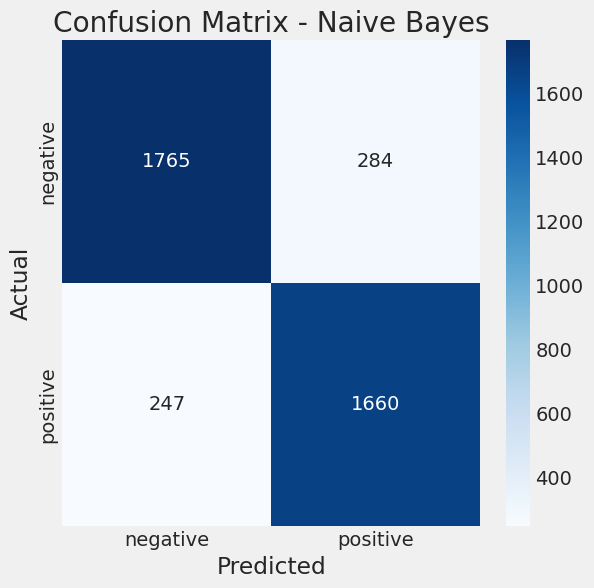


Support Vector Machine Results:
Accuracy: 0.8799

Classification Report:
              precision    recall  f1-score   support

    negative       0.90      0.87      0.88      2049
    positive       0.86      0.90      0.88      1907

    accuracy                           0.88      3956
   macro avg       0.88      0.88      0.88      3956
weighted avg       0.88      0.88      0.88      3956



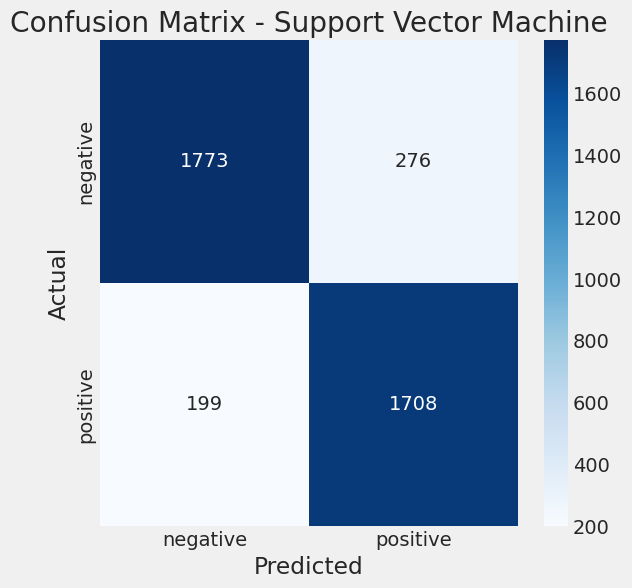


Random Forest Results:
Accuracy: 0.8524

Classification Report:
              precision    recall  f1-score   support

    negative       0.85      0.86      0.86      2049
    positive       0.85      0.84      0.85      1907

    accuracy                           0.85      3956
   macro avg       0.85      0.85      0.85      3956
weighted avg       0.85      0.85      0.85      3956



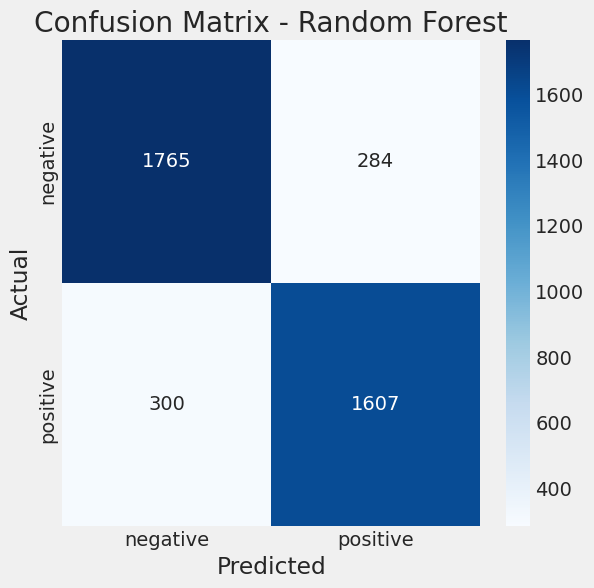

In [28]:
# Train and evaluate each model
for name, model in models.items():
    train_and_evaluate(model, name)

# **Hyperparameter Tuning**

Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best accuracy: 0.8837208134812586

Tuned Logistic Regression Results:
Accuracy: 0.8873

Classification Report:
              precision    recall  f1-score   support

    negative       0.91      0.87      0.89      2049
    positive       0.86      0.91      0.89      1907

    accuracy                           0.89      3956
   macro avg       0.89      0.89      0.89      3956
weighted avg       0.89      0.89      0.89      3956



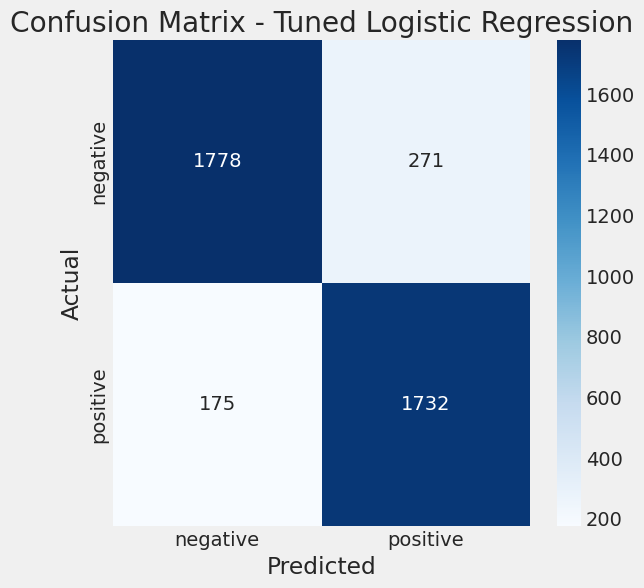

In [29]:
# Example for Logistic Regression
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

lr = LogisticRegression(max_iter=1000, random_state=42)
grid_search = GridSearchCV(lr, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_tfidf, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

# Evaluate best model
best_lr = grid_search.best_estimator_
train_and_evaluate(best_lr, 'Tuned Logistic Regression')

# **Final Model Selection and Evaluation**

In [30]:
# Compare all models
results_df = pd.DataFrame.from_dict(model_results, orient='index')
results_df['accuracy'] = results_df['accuracy'].apply(lambda x: f"{x:.4f}")
print(results_df[['accuracy']])

                          accuracy
Logistic Regression         0.8880
Naive Bayes                 0.8658
Support Vector Machine      0.8799
Random Forest               0.8524
Tuned Logistic Regression   0.8873


In [31]:
# Select best model based on accuracy
best_model_name = max(model_results, key=lambda x: model_results[x]['accuracy'])
best_model = models[best_model_name]
print(f"\nBest Model: {best_model_name}")


Best Model: Logistic Regression


In [32]:
# You can save the best model for future use
import joblib
joblib.dump(best_model, 'best_sentiment_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

# **Create a Prediction Function**

In [35]:
def predict_sentiment(text):
    # Load the saved model and vectorizer
    model = joblib.load('best_sentiment_model.pkl')
    vectorizer = joblib.load('tfidf_vectorizer.pkl')

    # Clean the input text
    cleaned_text = clean_text(text)

    # Transform the text using the vectorizer
    text_tfidf = vectorizer.transform([cleaned_text])

    # Make prediction
    prediction = model.predict(text_tfidf)
    probability = model.predict_proba(text_tfidf)

    # Return result
    sentiment = 'positive' if prediction[0] == 1 else 'negative'
    confidence = probability[0][prediction[0]]

    return {
        'sentiment': sentiment,
        'confidence': float(confidence),
        'probability_positive': float(probability[0][1]),
        'probability_negative': float(probability[0][0])
    }

# Test the function
sample_review = "This movie was fantastic! The acting was superb and the plot was engaging."
print(predict_sentiment(sample_review))

sample_review2 = "I hated this movie. The acting was terrible and the story made no sense."
print(predict_sentiment(sample_review2))

{'sentiment': 'positive', 'confidence': 0.8218172393090577, 'probability_positive': 0.8218172393090577, 'probability_negative': 0.1781827606909423}
{'sentiment': 'negative', 'confidence': 0.9101645187736079, 'probability_positive': 0.08983548122639207, 'probability_negative': 0.9101645187736079}


# **Create a Summary Report**

In [36]:
# Generate a markdown report
report = f"""
# IMDb Movie Review Sentiment Analysis Report

## Dataset Overview
- Total reviews: {len(df)}
- Positive reviews: {len(df[df['sentiment'] == 'positive'])}
- Negative reviews: {len(df[df['sentiment'] == 'negative'])}

## Preprocessing Steps
1. Text cleaning (lowercase, remove special characters)
2. Tokenization
3. Stopword removal
4. Lemmatization
5. Added text statistics (word count, character count, average word length)

## Feature Extraction
- Used TF-IDF vectorization with max_features=10000 and ngram_range=(1, 2)

## Model Performance Comparison
{results_df[['accuracy']].to_markdown()}

## Best Model
- Model: {best_model_name}
- Accuracy: {model_results[best_model_name]['accuracy']:.4f}

## Key Findings
- The dataset was balanced between positive and negative reviews
- Reviews typically contained between 50-150 words
- The {best_model_name} performed best among the tested models
- Common positive words included 'film', 'movie', 'great', 'good'
- Common negative words included 'movie', 'film', 'bad', 'worst'
"""

print(report)

# Save report to file
with open('sentiment_analysis_report.md', 'w') as f:
    f.write(report)


# IMDb Movie Review Sentiment Analysis Report

## Dataset Overview
- Total reviews: 19780
- Positive reviews: 9786
- Negative reviews: 9993

## Preprocessing Steps
1. Text cleaning (lowercase, remove special characters)
2. Tokenization
3. Stopword removal
4. Lemmatization
5. Added text statistics (word count, character count, average word length)

## Feature Extraction
- Used TF-IDF vectorization with max_features=10000 and ngram_range=(1, 2)

## Model Performance Comparison
|                           |   accuracy |
|:--------------------------|-----------:|
| Logistic Regression       |     0.888  |
| Naive Bayes               |     0.8658 |
| Support Vector Machine    |     0.8799 |
| Random Forest             |     0.8524 |
| Tuned Logistic Regression |     0.8873 |

## Best Model
- Model: Logistic Regression
- Accuracy: 0.8880

## Key Findings
- The dataset was balanced between positive and negative reviews
- Reviews typically contained between 50-150 words
- The Logistic Regress